# Backtesting with refit and rolling training window
### Single and Multiple Dependent time series (Multivariate): Direct forecasting
Note: The arguments needed to achieve this configuration are `refit=True` and `fixed_train_size=True`.  
Conda environment: `time-series`  
05 Jul 2024

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Single time series

### 1.1) Input data

In [4]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222


In [5]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [6]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


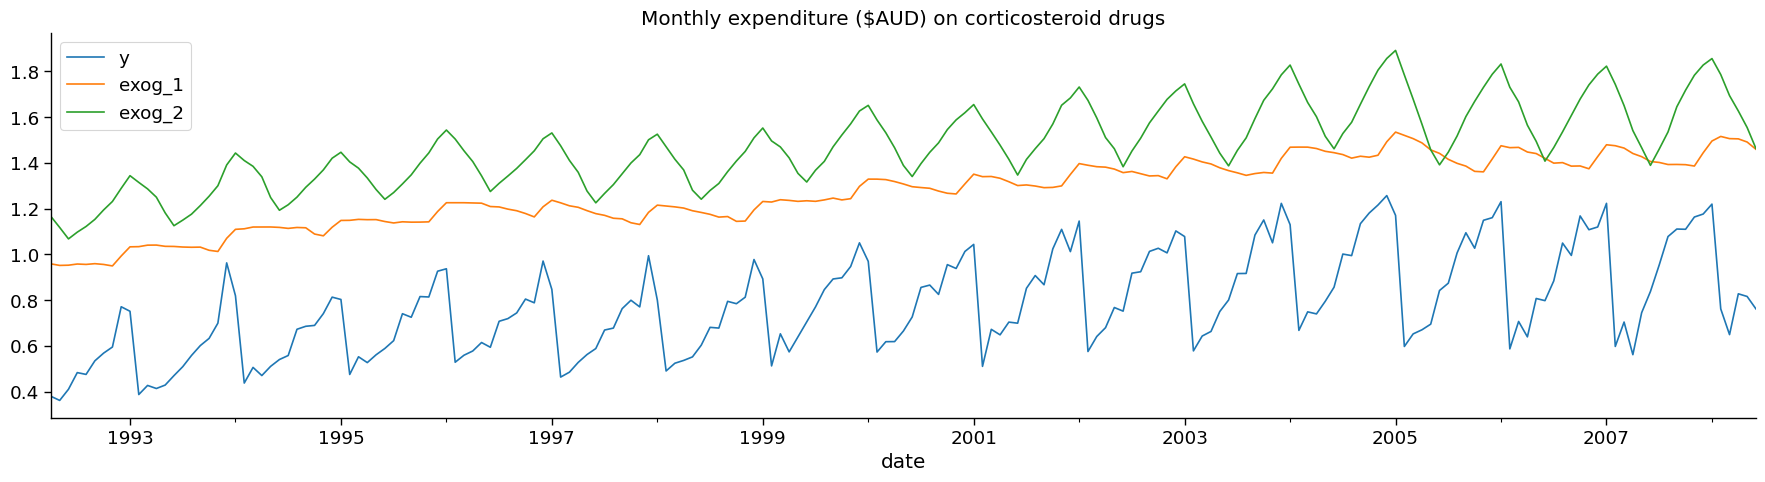

In [9]:
data.plot()

plt.title("Monthly expenditure ($AUD) on corticosteroid drugs")
plt.show()

### 1.2) Direct Forecasting

In [14]:
# Create forecaster
HORIZON = 7  # Number of steps to forecast

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1, random_state=123),
    lags=6,
    steps=HORIZON,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Number of datapoints to test over
n_backtesting = HORIZON * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    fixed_train_size=True,
    allow_incomplete_fold=True, # new concept 
    steps=HORIZON,
    metric="mean_squared_error",
    refit=True,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-11-01 00:00:00 -- 2007-04-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1993-06-01 00:00:00 -- 2007-11-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00, 13.84it/s]

Backtest metric (MSE): 0.011914023663703708


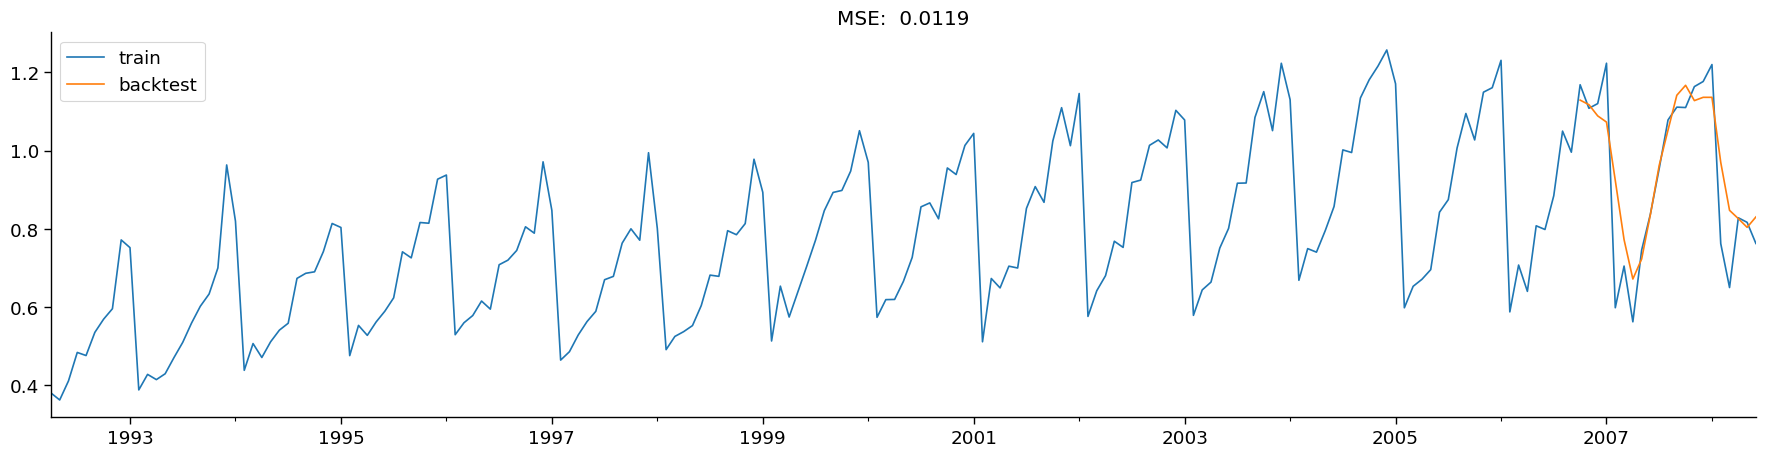

In [21]:
error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

fig, ax = plt.subplots()

data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend()

plt.xlabel("")
plt.title(f"MSE: {error_mse: .4f}")
plt.show()

In [23]:
# Custom metric
def custom_metric(y_true, y_pred):
    """
    Calculate the MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Backtesting
# Number of datapoints to test over
n_backtesting = HORIZON * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    fixed_train_size=True,
    allow_incomplete_fold=True,
    steps=HORIZON,
    metric=custom_metric,
    refit=True,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MAPE): {metric:.4}%")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-11-01 00:00:00 -- 2007-04-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1993-06-01 00:00:00 -- 2007-11-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00, 43.92it/s]

Backtest metric (MAPE): 9.474%


## 2) Multiple Dependent time-series (Multivariate)

In [24]:
# Load the data
data = fetch_dataset(name="air_quality_valencia", raw=True)
data

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26129, 11)


,datetime,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
0,2020-01-01 00:00:00,77.0000,0.2000,16.0000,45.0000,83.0000,69.0000,3.0000,0.3000,16.0000,7.0000
1,2020-01-01 01:00:00,65.0000,0.2000,20.0000,37.0000,70.0000,68.0000,3.0000,0.2000,21.0000,5.0000
2,2020-01-01 02:00:00,47.0000,0.1000,16.0000,35.0000,51.0000,61.0000,3.0000,0.2000,35.0000,5.0000
3,2020-01-01 03:00:00,43.0000,0.1000,16.0000,29.0000,46.0000,53.0000,3.0000,0.1000,71.0000,5.0000
4,2020-01-01 04:00:00,36.0000,0.1000,10.0000,23.0000,39.0000,39.0000,3.0000,0.1000,236.0000,4.0000
...,...,...,...,...,...,...,...,...,...,...,...
26124,2019-12-31 19:00:00,31.0000,0.3000,1.0000,29.0000,33.0000,31.0000,35.0000,0.1000,162.0000,3.0000
26125,2019-12-31 20:00:00,34.0000,0.2000,33.0000,57.0000,37.0000,107.0000,6.0000,0.1000,172.0000,5.0000
26126,2019-12-31 21:00:00,47.0000,0.3000,92.0000,73.0000,50.0000,213.0000,3.0000,0.2000,289.0000,9.0000
26127,2019-12-31 22:00:00,54.0000,0.2000,30.0000,58.0000,58.0000,103.0000,3.0000,0.2000,356.0000,7.0000


In [25]:
# Data preprocessing
data["datetime"] = pd.to_datetime(data["datetime"])
data = data.set_index("datetime")
data = data.asfreq("H")
data = data.sort_index()
data = data[["co", "so2", "pm2.5"]]
data.head()

,co,so2,pm2.5
datetime,,,
2019-01-01 00:00:00,0.2000,8.0000,19.0000
2019-01-01 01:00:00,0.1000,8.0000,26.0000
2019-01-01 02:00:00,0.1000,8.0000,31.0000
2019-01-01 03:00:00,0.1000,10.0000,30.0000
2019-01-01 04:00:00,0.1000,11.0000,30.0000


In [26]:
data.isnull().any()

co       True
so2      True
pm2.5    True
dtype: bool

In [27]:
# Impute missing values with forward filling
data = data.ffill()

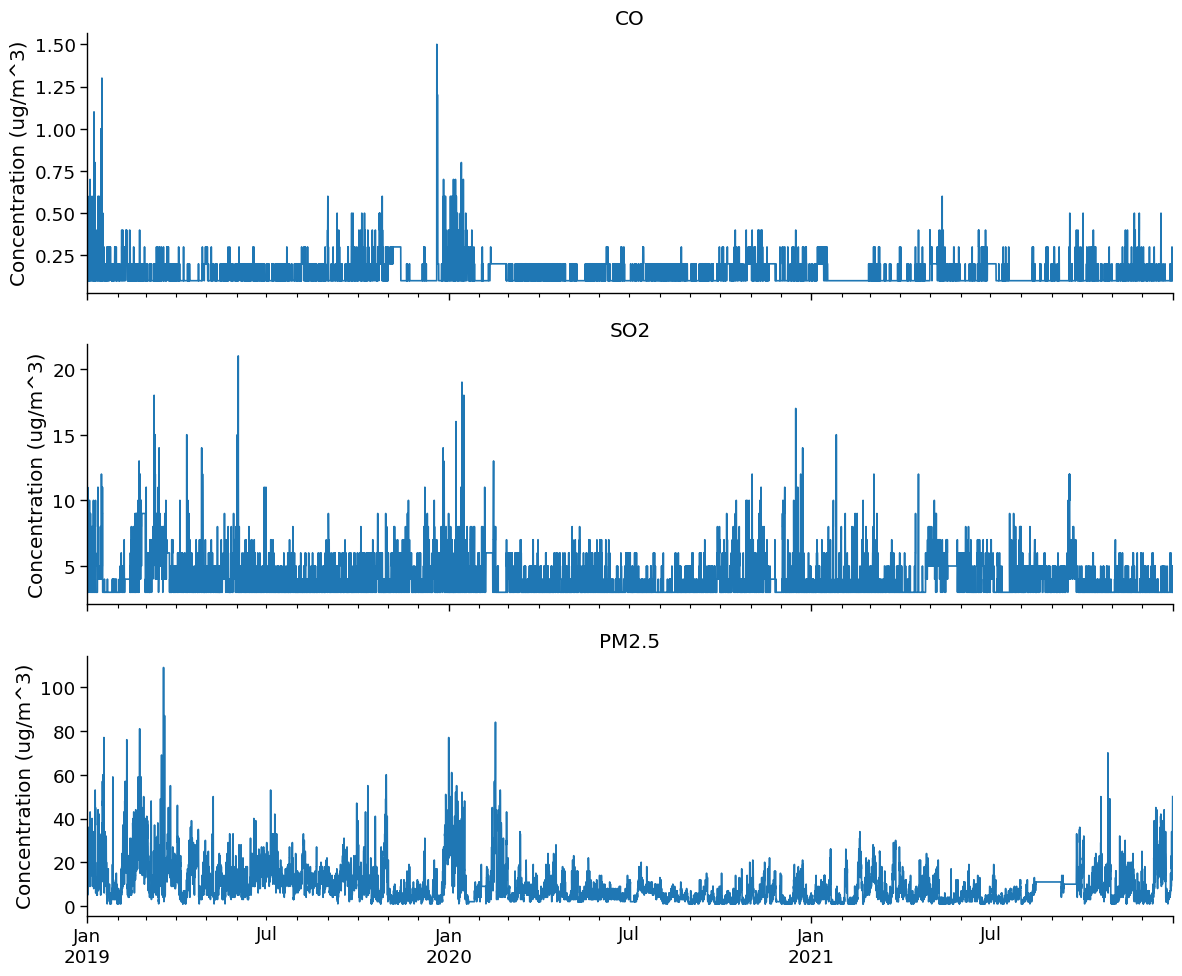

In [32]:
# Plot time series
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

data["co"].plot(ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Concentration (ug/m^3)")
axes[0].set_title("CO")

data["so2"].plot(ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Concentration (ug/m^3)")
axes[1].set_title("SO2")

data["pm2.5"].plot(ax=axes[2])
axes[2].set_xlabel("")
axes[2].set_ylabel("Concentration (ug/m^3)")
axes[2].set_title("PM2.5")

fig.tight_layout()
plt.show()

In [33]:
data["day_of_week"] = data.index.weekday
data

,co,so2,pm2.5,day_of_week
datetime,,,,
2019-01-01 00:00:00,0.2000,8.0000,19.0000,1
2019-01-01 01:00:00,0.1000,8.0000,26.0000,1
2019-01-01 02:00:00,0.1000,8.0000,31.0000,1
2019-01-01 03:00:00,0.1000,10.0000,30.0000,1
2019-01-01 04:00:00,0.1000,11.0000,30.0000,1
...,...,...,...,...
2021-12-31 19:00:00,0.1000,3.0000,31.0000,4
2021-12-31 20:00:00,0.1000,4.0000,33.0000,4
2021-12-31 21:00:00,0.1000,5.0000,34.0000,4


### 2.2) Direct Forecasting

In [38]:
forecaster = ForecasterAutoregMultiVariate(
    regressor=Ridge(alpha=1),
    level="co", # this is the target time series
    lags=31,
    steps=24,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Define column names of target variables that define the multivariate series
target_cols = ["co", "so2", "pm2.5"]

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 24

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    steps=steps,
    allow_incomplete_fold=True,
    metric="mean_absolute_error",
    fixed_train_size=True,
    refit=True,
    verbose=True,
    show_progress=True,
)

/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/skforecast/model_selection_multiseries/model_selection_multiseries.py:222: LongTrainingWarning: The forecaster will be fit 72 times (3 folds * 24 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 26232
Number of observations used for backtesting: 72
    Number of folds: 3
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-12-28 23:00:00  (n=26232)
    Validation: 2021-12-29 00:00:00 -- 2021-12-29 23:00:00  (n=24)
Fold: 1
    Training:   2019-01-02 00:00:00 -- 2021-12-29 23:00:00  (n=26232)
    Validation: 2021-12-30 00:00:00 -- 2021-12-30 23:00:00  (n=24)
Fold: 2
    Training:   2019-01-03 00:00:00 -- 2021-12-30 23:00:00  (n=26232)
    Validation: 2021-12-31 00:00:00 -- 2021-12-31 23:00:00  (n=24)



100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


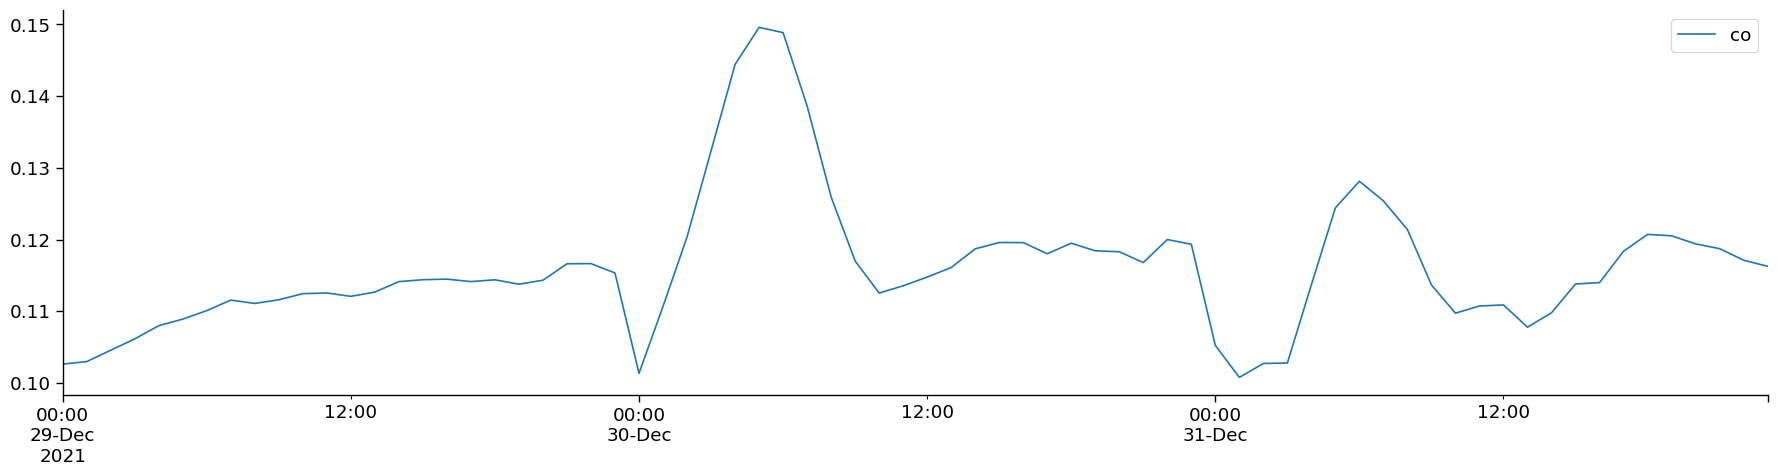

In [40]:
predictions.plot()
plt.show()